<a href="https://colab.research.google.com/github/PeiZheng224/AI-Powered-Marketing-Content-Pipeline/blob/main/instacart_1/takehomefile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Instacart](https://raw.githubusercontent.com/interviewquery/takehomes/instacart_1/instacart_1/logo.png)
# Data Analyst Challenge

## Directions

We'd love for you to analyze the data in `data.csv` and share what you find. We know
that you don't know much about how our team currently is run, but that's
okay. This data set includes information on orders, order location,
customer ratings, and any issues reported by the customer for a set of
orders.

1. Please analyze the data in the adjacent tab and share with us the

    1. any observations about our business.

    1. How would you staff the Customer Support Team?

Please compile your analysis into a document or deck to convey your
findings. Use the Data Set as necessary to substantiate your claims.


In [5]:
!git clone --branch instacart_1 https://github.com/interviewquery/takehomes.git
%cd takehomes/instacart_1
!ls

Cloning into 'takehomes'...
remote: Enumerating objects: 1968, done.
remote: Counting objects: 100% (1968/1968), done.
remote: Compressing objects: 100% (1222/1222), done.
remote: Total 1968 (delta 755), reused 1933 (delta 729), pack-reused 0 (from 0)
Receiving objects: 100% (1968/1968), 299.41 MiB | 14.85 MiB/s, done.
Resolving deltas: 100% (755/755), done.
/content/takehomes/instacart_1/takehomes/instacart_1
data.csv  logo.png  metadata.json  takehomefile.ipynb


In [6]:
#write your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df=pd.read_csv('data.csv')

**整体思路**：先看单一指标 → 再做关联探索 → 再结合业务价值排序 → 最后提出可执行建议（staffing、SLA、CX改进等）
## SQL
Use SQL to read data, constructing next steps useful for business inisghts.

In [8]:
# !pip install sqlalchemy
from sqlalchemy import create_engine

In [9]:
engine = create_engine("sqlite:///customer_data.sqlite")

df.to_sql("customer_data", engine, if_exists="replace", index=False)
df_query = pd.read_sql("SELECT * FROM customer_data", engine)

In [10]:
df_query

,order delivery time,order id,customer order rating,type of issue reported,region
0,2014-06-02 04:23:16 UTC,233599337,5,None,chi
1,2014-06-02 03:57:50 UTC,233599376,5,None,chi
2,2014-06-02 02:52:38 UTC,233599328,5,None,chi
3,2014-06-02 02:52:04 UTC,233599070,5,None,chi
4,2014-06-02 02:41:43 UTC,233599100,5,None,chi
...,...,...,...,...,...
14952,2014-05-07 20:29:32 +0000,233614661,0,None,sf
14953,2014-05-05 23:59:17 +0000,233614666,0,None,sf
14954,2014-05-04 22:48:29 +0000,233614671,0,None,sf
14955,2014-05-03 17:41:36 +0000,233614676,0,None,sf


In [11]:
distinct_regions_df = pd.read_sql("SELECT DISTINCT region FROM customer_data", engine)
display(distinct_regions_df)

,region
0,chi
1,nyc
2,sf
3,sf


发现sf数据重复，因为有space的差别，做数据清洗修正这个错误

‼️是否有其他更好/常规的方法来做这步？

In [18]:
# Clean the 'region' column by stripping whitespace
df['region'] = df['region'].str.strip()

# Update the SQL table with the cleaned data
df.to_sql("customer_data", engine, if_exists="replace", index=False)

# Now, let's check the distinct regions again after cleaning
query_distinct_regions_cleaned = """
SELECT DISTINCT region FROM customer_data;
"""
distinct_regions_cleaned_df = pd.read_sql(query_distinct_regions_cleaned, engine)
display(distinct_regions_cleaned_df)

,region
0,chi
1,nyc
2,sf


In [25]:
query = """
SELECT `order id`, count(`order id`) as count, region
FROM customer_data
GROUP BY `order id`
ORDER BY count DESC
"""
OrderId_df = pd.read_sql(query, engine)
display(OrderId_df)

,order id,count,region
0,233598760,6,chi
1,246371,6,sf
2,237775,6,nyc
3,228263,5,sf
4,226403,5,sf
...,...,...,...
13840,215936,1,chi
13841,215925,1,sf
13842,214101,1,nyc
13843,214084,1,nyc


In [43]:
# 看不同地区的使用频率
distribution_by_region_and_order_count = OrderId_df.groupby(['region', 'count']).size().reset_index(name='occurrence')

display(distribution_by_region_and_order_count)

,region,count,occurrence,average_rating
0,chi,1,5577,4.759190
1,chi,2,343,4.558309
2,chi,3,47,4.000000
3,chi,4,5,2.900000
4,chi,6,1,1.000000
5,nyc,1,1132,4.555654
6,nyc,2,59,3.838983
7,nyc,3,6,3.166667
8,nyc,4,4,1.937500
9,nyc,6,1,3.000000


In [28]:
query = """
SELECT `customer order rating` as rating, count(`customer order rating`) as count
FROM customer_data
GROUP BY `customer order rating`
ORDER BY rating DESC
"""
rating_df = pd.read_sql(query, engine)
display(rating_df)

,rating,count
0,5,11602
1,4,1680
2,3,778
3,2,370
4,1,373
5,0,154


Here is the distribution of customer order ratings and their respective proportions:

In [30]:
# Calculate the total count of all ratings
total_ratings = rating_df['count'].sum()

# Calculate the proportion for each rating
rating_df['proportion'] = rating_df['count'] / total_ratings

display(rating_df)

,rating,count,proportion
0,5,11602,0.775690
1,4,1680,0.112322
2,3,778,0.052016
3,2,370,0.024738
4,1,373,0.024938
5,0,154,0.010296


77.5%的5星好评率 -> 并不算高  
差评率（<= 3星）-> 约等于6%

In [21]:
query = """
SELECT MIN(`order delivery time`) AS earliest_delivery_time,
       MAX(`order delivery time`) AS latest_delivery_time
FROM customer_data
"""
time_range_df = pd.read_sql(query, engine)
display(time_range_df)

,earliest_delivery_time,latest_delivery_time
0,2014-05-01 08:54:00 +0000,2014-06-02 06:28:37 +0000


In [22]:
query = """
SELECT `type of issue reported`, COUNT(*) as count
FROM customer_data
GROUP BY `type of issue reported`
ORDER BY count DESC
"""
issue_counts_df = pd.read_sql(query, engine)
display(issue_counts_df)

,type of issue reported,count
0,None,13870
1,Wrong item,374
2,Damaged or spoiled,310
3,Item missing,178
4,Poor service,129
5,Poor replacement,54
6,Other Order Issue,21
7,Item charged incorrectly,21


Here is the distribution of reported issue types and their respective proportions:

In [31]:
# Calculate the total count of all issues
total_issues = issue_counts_df['count'].sum()

# Calculate the proportion for each issue type
issue_counts_df['proportion'] = issue_counts_df['count'] / total_issues

display(issue_counts_df)

,type of issue reported,count,proportion
0,None,13870,0.927325
1,Wrong item,374,0.025005
2,Damaged or spoiled,310,0.020726
3,Item missing,178,0.011901
4,Poor service,129,0.008625
5,Poor replacement,54,0.003610
6,Other Order Issue,21,0.001404
7,Item charged incorrectly,21,0.001404


- 92.7%无事发生
- 产品问题：wrong item + damaged/spoiled + item missing -> 占比5.7%  
- 服务问题：poor service + poor replacement -> 1.2%  
- logistical issue: item charged incoorectly -> 0.1%  
由此可知，重点首先应放在提升产品本身上，也就是和商家之间的沟通和选择更优质的商家

## Now look into relationships
### Customer Rating Distribution - Rating as Measurement

Rating & Region

In [24]:
query = """
SELECT region AS Region, AVG(`customer order rating`) AS Average_Rating, COUNT(*) AS Count
FROM customer_data
GROUP BY `region`
ORDER BY `Average_Rating` DESC
"""
rating_region_df = pd.read_sql(query, engine)
display(rating_region_df)

,Region,Average_Rating,Count
0,chi,4.711820,6430
1,sf,4.444383,7237
2,nyc,4.431008,1290


**Takeaway**: 三个地区的平均分数没有差很多，其中chi (Chicago?)可以尤其注意，做的好的地方，因为这个区域的评分又高，订单量又多（当然，订单量最好是和人口/目标客群的比值来比最有效）

**不同地区，消费不同次数（count）的人的个数（occurrence）和与之对应的average_rating**

In [44]:
# Calculate the average rating for each unique order_id from the original data
order_id_ratings = df.groupby('order id')['customer order rating'].mean().reset_index()
order_id_ratings.rename(columns={'customer order rating': 'average_rating_per_order'}, inplace=True)

# Merge OrderId_df with order_id_ratings to bring in the 'average_rating_per_order' for each order_id
OrderId_df_with_ratings = pd.merge(OrderId_df, order_id_ratings, on='order id', how='left')

# Now, group this new DataFrame by 'region' and 'count' and calculate the average of 'average_rating_per_order'
distribution_by_region_and_order_count = OrderId_df_with_ratings.groupby(['region', 'count']).agg(
    occurrence=('order id', 'size'),  # Keep the original 'occurrence' logic (number of order_ids in this group)
    average_rating=('average_rating_per_order', 'mean') # Add the average rating for orders in this group
).reset_index()

display(distribution_by_region_and_order_count)

,region,count,occurrence,average_rating
0,chi,1,5577,4.759190
1,chi,2,343,4.558309
2,chi,3,47,4.000000
3,chi,4,5,2.900000
4,chi,6,1,1.000000
5,nyc,1,1132,4.555654
6,nyc,2,59,3.838983
7,nyc,3,6,3.166667
8,nyc,4,4,1.937500
9,nyc,6,1,3.000000


这个数据就非常奇怪了，消费的多，评分怎么还低？

或许是因为我理解错了order id的意思？order id的意思是每一单，所以count对应的是每一单的物品数量而非一个月同一个人消费的总次数？

Rating & Type of Issue Reported

In [33]:
query = """
SELECT `type of issue reported`, AVG(`customer order rating`) AS Average_Rating, COUNT(*) AS Count
FROM customer_data
GROUP BY `type of issue reported`
ORDER BY `Average_Rating` DESC
"""
rating_issue_df = pd.read_sql(query, engine)
display(rating_issue_df)

,type of issue reported,Average_Rating,Count
0,None,4.683345,13870
1,Item charged incorrectly,4.190476,21
2,Other Order Issue,3.190476,21
3,Wrong item,3.144385,374
4,Damaged or spoiled,2.925806,310
5,Item missing,2.915730,178
6,Poor service,2.542636,129
7,Poor replacement,2.481481,54


这条可以看出哪些地方做的特别不好容易导致差评，对那些count多+评分低的项要尤其注意，应第一时间改进。如damaged, missing, poor service这种情况。特别是poor service因为这个是我方比较可控的。

Rating & Time

In [35]:
query_hourly_metrics = """
SELECT
    STRFTIME('%H', REPLACE(REPLACE(`order delivery time`, ' UTC', ''), ' +0000', '')) AS Hour_of_Day,
    COUNT(`order id`) AS Orders_Count,
    AVG(`customer order rating`) AS Average_Rating
FROM
    customer_data
GROUP BY
    Hour_of_Day
ORDER BY
    Hour_of_Day;
"""
hourly_metrics_df = pd.read_sql(query_hourly_metrics, engine)
display(hourly_metrics_df)

,Hour_of_Day,Orders_Count,Average_Rating
0,00,1431,4.546471
1,01,1293,4.512761
2,02,1080,4.550926
3,03,700,4.504286
4,04,416,4.560096
5,05,232,4.366379
6,06,56,3.767857
7,07,9,2.444444
8,08,3,3.333333
9,09,6,2.166667


In [ ]:
Hour of Day

In [37]:
# Create a new column 'Hour_Range' with human-readable format
hourly_metrics_df['Hour_Range'] = hourly_metrics_df['Hour_of_Day'].apply(lambda x: f"{x}:00-{int(x):02d}:59")

# Display the DataFrame with the new human-readable hour range
display(hourly_metrics_df[['Hour_Range', 'Orders_Count', 'Average_Rating']])

,Hour_Range,Orders_Count,Average_Rating
0,00:00-00:59,1431,4.546471
1,01:00-01:59,1293,4.512761
2,02:00-02:59,1080,4.550926
3,03:00-03:59,700,4.504286
4,04:00-04:59,416,4.560096
5,05:00-05:59,232,4.366379
6,06:00-06:59,56,3.767857
7,07:00-07:59,9,2.444444
8,08:00-08:59,3,3.333333
9,09:00-09:59,6,2.166667


/tmp/ipython-input-1973344163.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(hourly_metrics_df['Hour_Range'], rotation=45, ha='right')


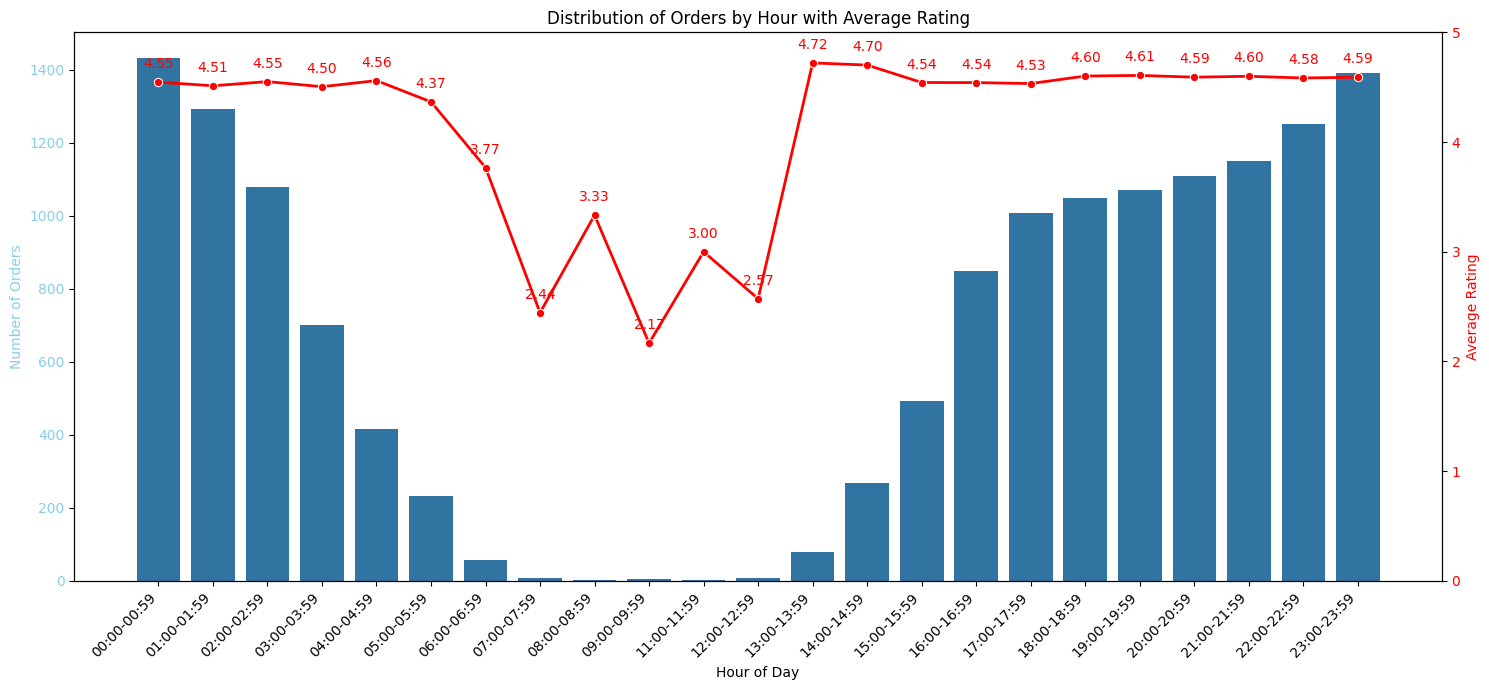

In [42]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Orders_Count as bar chart on the primary y-axis
sns.barplot(x='Hour_Range', y='Orders_Count', data=hourly_metrics_df, ax=ax1)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Orders', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Distribution of Orders by Hour with Average Rating')
ax1.set_xticklabels(hourly_metrics_df['Hour_Range'], rotation=45, ha='right')

# Create a secondary y-axis for Average_Rating
ax2 = ax1.twinx()
# Plot Average_Rating as a line chart on the secondary y-axis
sns.lineplot(x='Hour_Range', y='Average_Rating', data=hourly_metrics_df, ax=ax2, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Average Rating', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0, top=5) # Assuming ratings are 0-5

# Add average rating labels to the line plot
for x_pos, y_pos in enumerate(hourly_metrics_df['Average_Rating']):
    ax2.text(x_pos, y_pos + 0.1, f'{y_pos:.2f}', color='red', ha='center', va='bottom') # Adjust y_pos for label placement

plt.tight_layout()
plt.show()

可以看出，订单量本身和是否好评关系不大，和时段有关系，清晨到上午这个时段的好评是最少的

Day-of-week

In [47]:
query_daily_metrics = """
SELECT
    STRFTIME('%w', REPLACE(REPLACE(`order delivery time`, ' UTC', ''), ' +0000', '')) AS Day_of_Week_Num, -- %w for weekday number (0=Sunday, 6=Saturday)
    COUNT(`order id`) AS Orders_Count,
    AVG(`customer order rating`) AS Average_Rating
FROM
    customer_data
GROUP BY
    Day_of_Week_Num
ORDER BY
    Day_of_Week_Num;
"""
daily_metrics_df = pd.read_sql(query_daily_metrics, engine)

# Map day numbers to human-readable day names
day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
# Convert Day_of_Week_Num to integer type before mapping
daily_metrics_df['Day_of_Week'] = daily_metrics_df['Day_of_Week_Num'].astype(int).map(day_names)

display(daily_metrics_df[['Day_of_Week', 'Orders_Count', 'Average_Rating']])

,Day_of_Week,Orders_Count,Average_Rating
0,Sunday,2588,4.528594
1,Monday,2381,4.517010
2,Tuesday,2051,4.533398
3,Wednesday,1729,4.510700
4,Thursday,1877,4.552477
5,Friday,2072,4.641892
6,Saturday,2259,4.622399


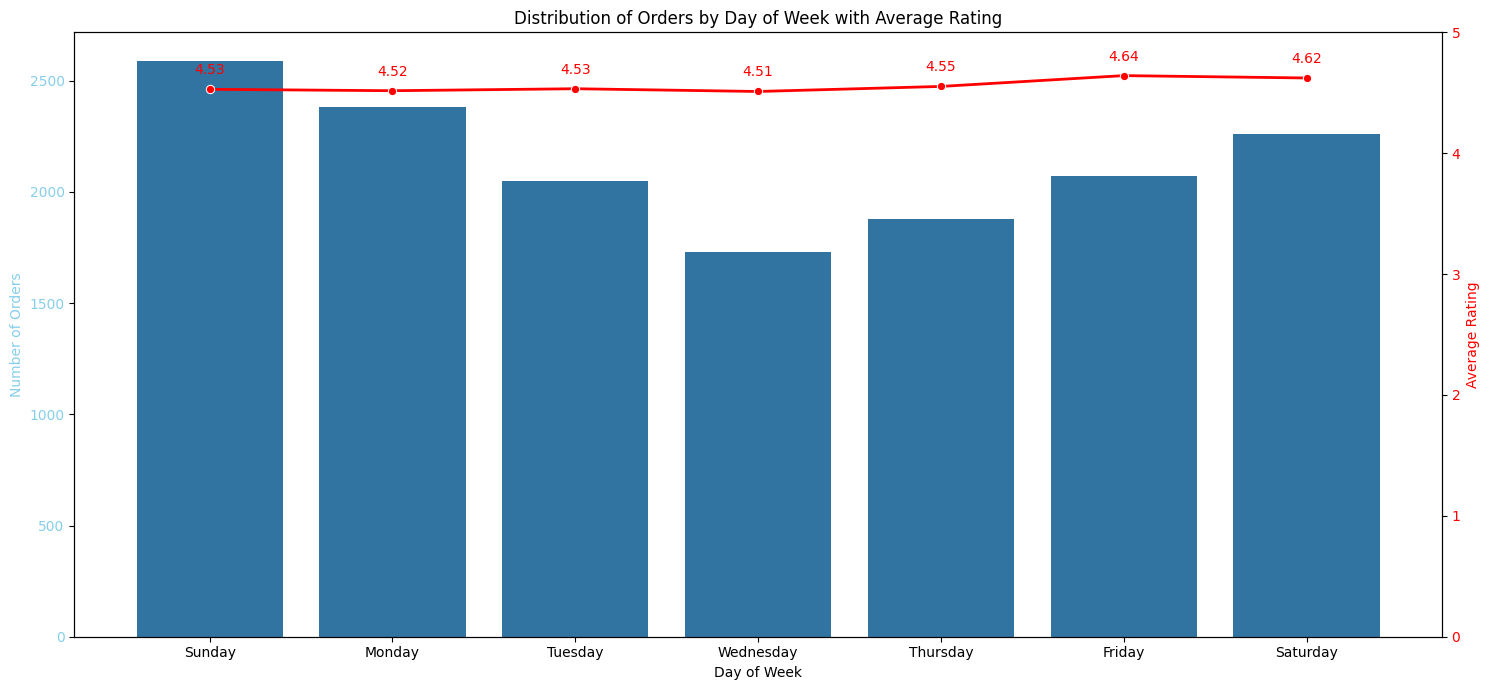

In [50]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Orders_Count as bar chart on the primary y-axis
sns.barplot(x='Day_of_Week', y='Orders_Count', data=daily_metrics_df, ax=ax1)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Number of Orders', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Distribution of Orders by Day of Week with Average Rating')
# ax1.set_xticklabels(daily_metrics_df['Day_of_Week'], rotation=45, ha='right') # No need to rotate if days are short

# Create a secondary y-axis for Average_Rating
ax2 = ax1.twinx()
# Plot Average_Rating as a line chart on the secondary y-axis
sns.lineplot(x='Day_of_Week', y='Average_Rating', data=daily_metrics_df, ax=ax2, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Average Rating', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0, top=5) # Assuming ratings are 0-5

# Add average rating labels to the line plot
for x_pos, y_pos in enumerate(daily_metrics_df['Average_Rating']):
    ax2.text(x_pos, y_pos + 0.1, f'{y_pos:.2f}', color='red', ha='center', va='bottom') # Adjust y_pos for label placement

plt.tight_layout()
plt.show()

按周来划分的话，呈现以周中为最低，两边渐渐增长的趋势

## Business Insights
总结以上数据的重点

挑出我们可以解决的问题（staffing、report issues），提出解决方案